In [1]:
import numpy as np
import matplotlib.pyplot as plt
import labrad_data_tools as ldt
import fitting_tools as fit

# Define scans to use

In [2]:
date = '20240912'
scantimes = ldt.get_subscantimes(date, '1430.57')
excludes = [[]] * len(scantimes)

# Define parameters

In [3]:
eta = 0.069
nbar_guess = 30
fix_fit_scale = False

# Define some convenience functions

In [4]:
def fit_rabi(date, scantime, exclude=[], plot=False):
    (x, y) = ldt.get_data(date, scantime, exclude=exclude)
    
    fitfunction = fit.rabi_flop_thermal()
    fixed_params = {'delta_kHz': 0,
                    'eta': eta,
                    'sideband_order': 0,
                    'turnon_delay_us': 0.0}
    guess_params = {'Omega_kHz': guess_omega_rabi(x, y),
                    'nbar': nbar_guess}
    if fix_fit_scale:
        fixed_params['scale'] = 1.0
    else:
        guess_params['scale'] = 0.9
    
    fitfunction.set_fixed_params(fixed_params)
    fitfunction.set_guess_params(guess_params)
    fitfunction.do_fit(x, y, use_qpn=True)
    
    if plot:
        xfit = np.linspace(min(x), max(x), 200)
        yfit = fitfunction.eval_with_fits(xfit)
        plt.plot(x, y, '.', label=scantime)
        plt.legend()
        plt.plot(xfit, yfit)
        plt.show()

    nbar = fitfunction.get_fits()['nbar']
    return nbar

def guess_omega_rabi(x, y):
    step = x[1] - x[0]
    mean = np.mean(y)
    for x0, y0 in zip(x,y):
        if y0 > mean: break
    t_2pi  = 4*(x0-step/2.0)
    return 1e3 * 1/(t_2pi)

def get_waittime(scantime):
    scantime = scantime.replace('.', '_')
    params = ldt.get_parameters(date, scantime)
    return params['EmptySequence.empty_sequence_duration']['ms']

# Fit the Rabi flops

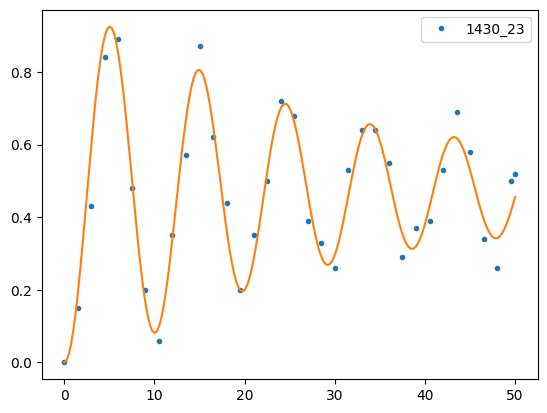

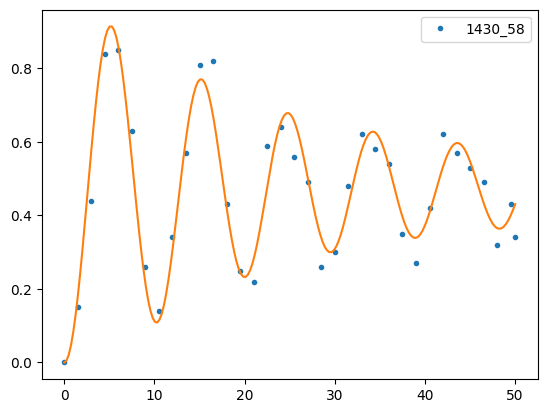

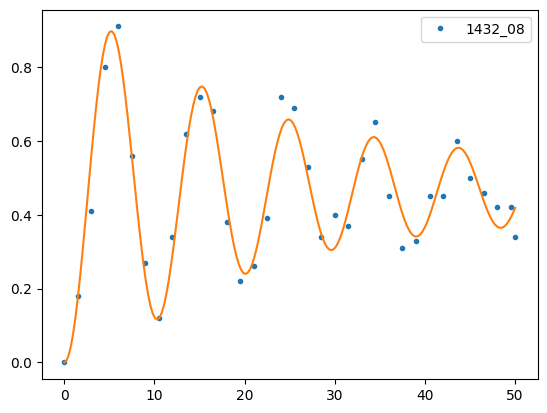

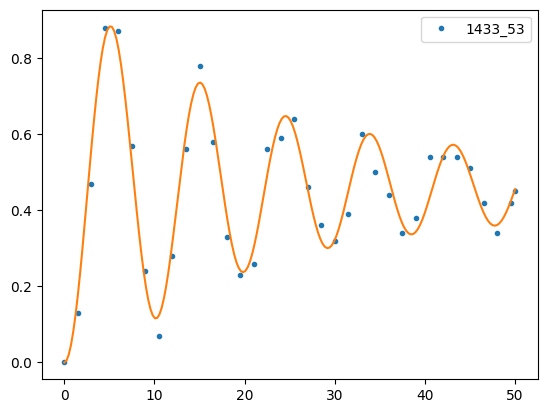

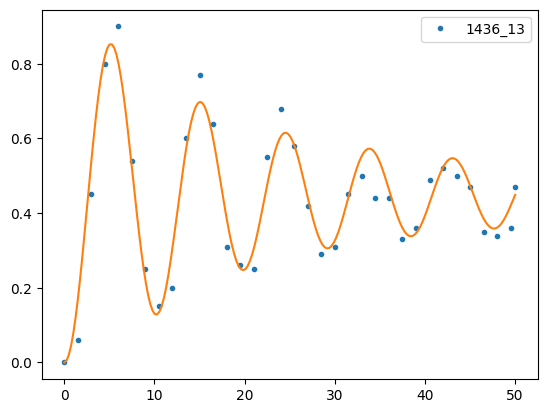

In [5]:
fits = [fit_rabi(date, scantime, exclude, plot=True) for (scantime, exclude) in zip(scantimes, excludes)]

In [6]:
waittimes = [get_waittime(scantime) for scantime in scantimes]
nbars = [fit[0] for fit in fits]
dnbars = [fit[1] for fit in fits]

# Fit nbar vs wait time to a line

In [7]:
fitfunc = fit.line()
fitfunc.set_fixed_params({})
fitfunc.set_guess_params({'m': 0.4,
                          'b': 23.0})
heating_rate_fit = fitfunc.do_fit(waittimes, nbars, yerr=dnbars)
heating_rate_fit

{'m': (0.22001843501103088, 0.05973319183768366),
 'b': (22.587205519232732, 1.250553920633208)}

# Plot fitted nbar vs wait time and the fitted heating rate

In [8]:
waittime_fit = np.linspace(min(waittimes), max(waittimes))
nbar_fit = fitfunc.eval_with_fits(waittime_fit)

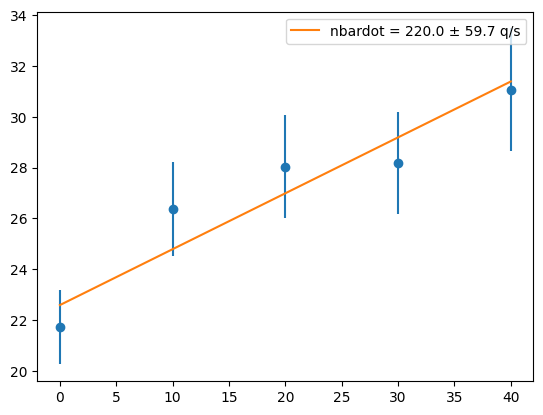

In [9]:
(fig, ax) = plt.subplots()

ax.errorbar(waittimes, nbars, dnbars, marker='o', linestyle='')
ax.plot(waittime_fit, nbar_fit, label='nbardot = {0:.1f} ± {1:.1f} q/s'.format(1e3*heating_rate_fit['m'][0], 1e3*heating_rate_fit['m'][1]))
ax.legend()

plt.show()

The heating rate is 220 ± 60 q/s.